In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate as correlate
from stationprocessing import fir_filter_coefficients, channelize_ppf_contiguous_block

channels = 512         # nr of channels in the PFB
taps = 16              # variable for the PFB
sample_rate = 2.5e6    # samples / second

In [8]:
#### Load the files here, use the [number:] if you already have a delay number to correct for
#### -n delay means [n:] for IQ0, n delay means [n:] for IQ1

path = "THUR_TEST/"#"EXPERIMENT/"

IQ0 = np.fromfile(path+"A0", dtype="complex64")
IQ1 = np.fromfile(path+"airspy0", dtype="complex64")[749823:]
#IQ0 = np.fromfile("EXPERIMENT/airspy0_LNA", dtype="complex64")[26297:]
#IQ1 = np.fromfile("EXPERIMENT/airspy1_LNA", dtype="complex64")[:]

In [9]:
#### Get the lengths of the files. These need not be equal, even after correcting for delay
#### since there also is a delay turning them off.
print("Original length:", len(IQ0), "Original time:", len(IQ0) / sample_rate)
print("Original length:", len(IQ1), "Original time:", len(IQ1) / sample_rate)

Original length: 154861097 Original time: 61.9444388
Original length: 154832634 Original time: 61.9330536


In [ ]:
#### resize arrays pre-calculation, to reduce needed cpu time
#### make sure the .copy() remains, since that will force a ram clean-up
#### 1s = 20MB/file = 2_500_000 samples/file, 1m = 1.2GB/file = 150_000_000 samples/file

resize_start = 300 #seconds
resize_end   = 450
IQ0 = IQ0[int(resize_start * sample_rate) : int(resize_end * sample_rate)].copy()
IQ1 = IQ1[int(resize_start * sample_rate) : int(resize_end * sample_rate)].copy()

print("Resized length:", len(IQ0))
print("Resized length:", len(IQ1))

In [ ]:
#### Plot magnitude of time-series data, to visually inspect start-up delay
plot_till = 1_000_000_000
step = 500_000
plt.plot(np.abs(IQ0[:plot_till][::step]), alpha=.6)
plt.plot(np.abs(IQ1[:plot_till][::step]), alpha=.6)
plt.xlabel("Number of steps")
plt.ylabel("Magnitude a.u.")
plt.title("Time-series magnitude as function of sample number")
plt.show()

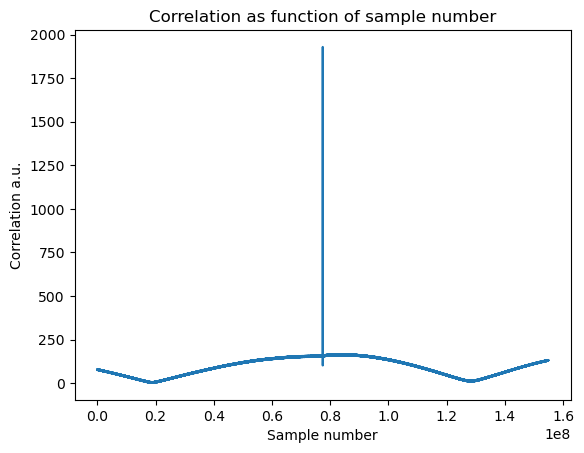

0


In [10]:
#### This code takes a while, only run on smaller subsets, or be prepared to wait a while
#### A very good measure however to test if your delay correction is correct.
#### The print should return 0, if the correction if proper, otherwise it prints the delay
#### It will onlt print the delay if the delay is constant, flat. If there is a non-constant delay, solve that first.
corr_abs = np.abs(correlate(IQ0, IQ1, mode='same', method='fft'))
plt.plot(corr_abs)
plt.xlabel("Sample number")
plt.ylabel("Correlation a.u.")
plt.title("Correlation as function of sample number")
plt.show()

print(len(IQ1)//2 - np.argmax(corr_abs))
%xdel corr_abs

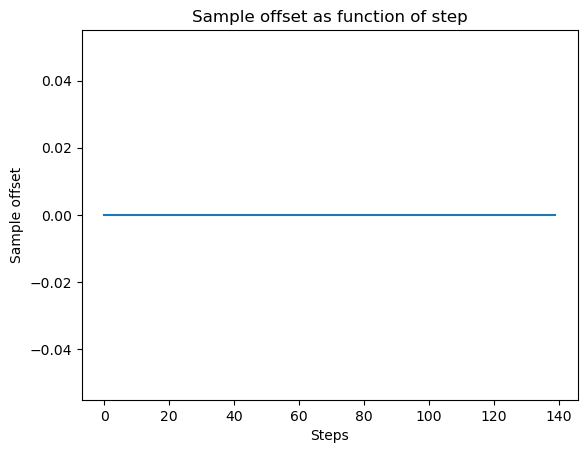

Mean 0.0
First 0
Last 0


In [11]:
#### This code is significantly faster, and used to track dropped samples by testing
#### coherency as function of time. Ignore the first [start] terms, then correlate
#### a subarray of length [upto], and jump through the full array at steps [step].
#### A straight line is expected. If it's not at 0, there is a full-sample delay between the two.

#### If the line is not flat, you have big problems.
#### If the line is linearly increasing, your clocks are at different frequencies, thus the GPS clock is either not connected or fucked.
#### If the line is all over the place, you are dropping samples and your data is useless. Or your step is larger than the samplle delay.

step  = 1_000_000         # Make sure step is larger than initial delay, otherwise it cannot find coherency
upto  = 2_000_000         # good value is >1x step, to make sure you aren't skipping data.
start = 10_000_000         # skip the initial portion, which likely isnt good anyway
end   = 150_000_000     # make sure this is less than your total arraysize.
dec   = 10               # decimation. Speeds up by this factor, though found shift is only accurate in steps of this.

if end > len(IQ0): end = np.min((len(IQ0), len(IQ1)))

arr = []
for s in np.arange(start, end, step).astype('int'):
    c = correlate(IQ0[s:s+upto:dec], IQ1[s:s+upto:dec], mode='same')
    shift = (upto // 2 - np.argmax(np.abs(c)) - (step - step//dec)) * dec
    #shift = upto // 2 - np.argmax(np.abs(c))
    arr += [shift]
plt.plot(arr)
plt.xlabel("Steps")
plt.ylabel("Sample offset")
plt.title("Sample offset as function of step")
plt.show()

print("Mean", np.mean(arr))
print("First", arr[0])
print("Last", arr[-1])

In [13]:
#### This code is preparational code for the 2D crosscorrelation.
#### It makes sure the lengths are multiples of the channel count, and that the arrays are equal length.
#### changing length to a multiple of channels
len0 = (IQ0.shape[0]//channels) * channels
len1 = (IQ1.shape[0]//channels) * channels
shortest = np.min((len0, len1))

IQ0 = IQ0[:shortest]
IQ1 = IQ1[:shortest]

l = IQ0.shape[0] / channels
time_len = len(IQ0) / sample_rate
time_len1 = len(IQ1) / sample_rate
print("Size of array:", len(IQ0), "\nObservation length (s):", time_len)
print("Size of array:", len(IQ1), "\nObservation length (s):", time_len1)

Size of array: 154832384 
Observation length (s): 61.9329536
Size of array: 154832384 
Observation length (s): 61.9329536


In [14]:
#### This cell reshapes the time-series data into channels.
#### The fit contains some coefficients for the PFB

IQ0 = IQ0.reshape((-1, channels))
IQ1 = IQ1.reshape((-1, channels))

fir = fir_filter_coefficients(channels, taps)

In [15]:
#### This is the actual FFT.

IQ0 = channelize_ppf_contiguous_block(IQ0, fir)
IQ1 = channelize_ppf_contiguous_block(IQ1, fir)

In [16]:
IQ0.shape

(302392, 512)

In [17]:
#### This calculates the phase of the crosscorrelation
cross_ang = np.angle(IQ0 * np.conj(IQ1))

In [18]:
#### This calculates the magnitude of the crosscorrelation
cross_abs = np.abs(IQ0 * np.conj(IQ1))

In [19]:
#### Plotting the 2D result.
#### Freq is the frequency range in MHz, ext and asp are parameters for the plt.imshow plotting, change asp
#### if the plot is weirdly shaped.

#### Expected result is a phase plot that is stable in time, and linear as function of frequency. 
#### If this is not the case, and its chaos or more regions than [-1, 0, 1] in terms of phase as function of frequency,
#### then your delay is incorrect. Chaos means its fucked, more than 3 regions means there is likely a sub-sample delay
#### which the earlier sub-array correlator cannot see.

freq = [1420 - 1.25, 1420 + 1.25]
ext = [freq[0], freq[1], 0, time_len]
asp = IQ0.shape[0] / time_len * (freq[1] - freq[0]) / channels / 256

In [25]:
#### 
half_way = channels // 2
cross_ang[:, half_way] = (cross_ang[:, half_way+1] + cross_ang[:, half_way-1]) / 2
cross_abs[:, half_way] = (cross_abs[:, half_way+1] + cross_abs[:, half_way-1]) / 2

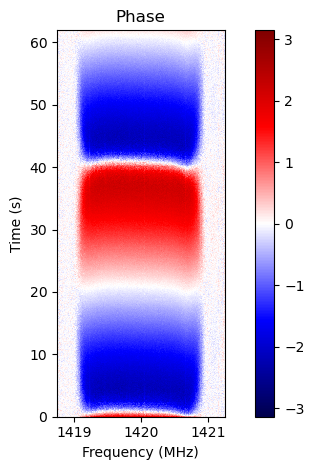

In [26]:
#### PHASE
plt.imshow(cross_ang[:, :], aspect=asp, vmin=-np.pi, vmax=np.pi, cmap='seismic', extent=ext, origin='lower')#, interpolation='none')
plt.colorbar()
plt.title("Phase")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Time (s)")
plt.tight_layout()
#plt.savefig("full_phase.png", dpi=300, bbox_inches='tight')
plt.show()

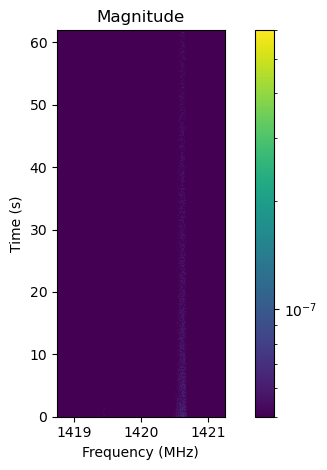

In [27]:
#### MAGNITUDE
plt.imshow(cross_abs, aspect=asp, extent=ext, origin='lower', norm='log', vmin=5e-8, vmax=6e-7)
plt.colorbar()
plt.xlabel("Frequency (MHz)")
plt.ylabel("Time (s)")
plt.title("Magnitude")
plt.tight_layout()
plt.show()

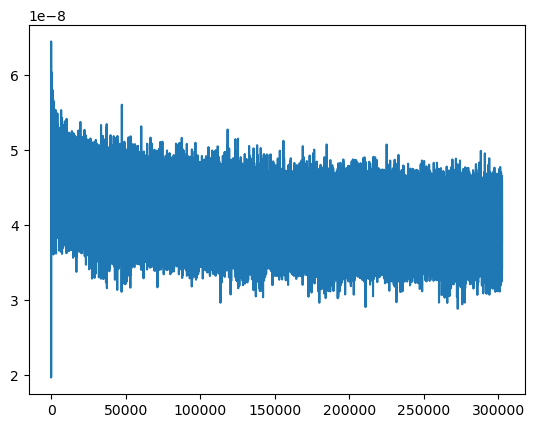

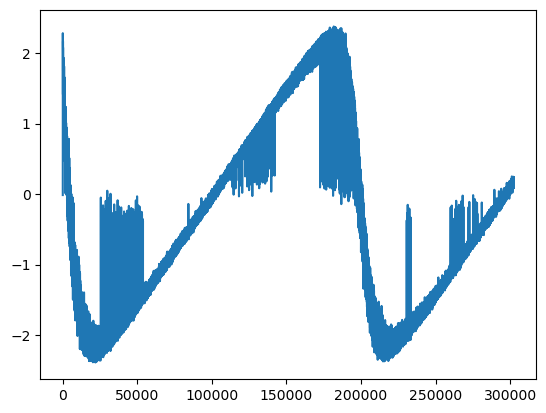

In [37]:
#### DEBUG plots, top one plots the magnitude as function of time, but summed over all frequencies,
#### bottom one is a histogram of the logarithm of all values in the full 2D magnitude diagram.

#remove the first and last [w] indices
w = 110

plt.plot(cross_abs[:, w:cross_abs.shape[1]-w].mean(axis=1))
plt.show()

# check for values found in plot, if you want other boundaries than vmin=min, vmax=max
#plt.hist(np.log10(cross_abs.flatten()), bins=100)
#plt.show()

plt.plot(cross_ang[:, w:cross_ang.shape[1]-w].mean(axis=1))
plt.show()

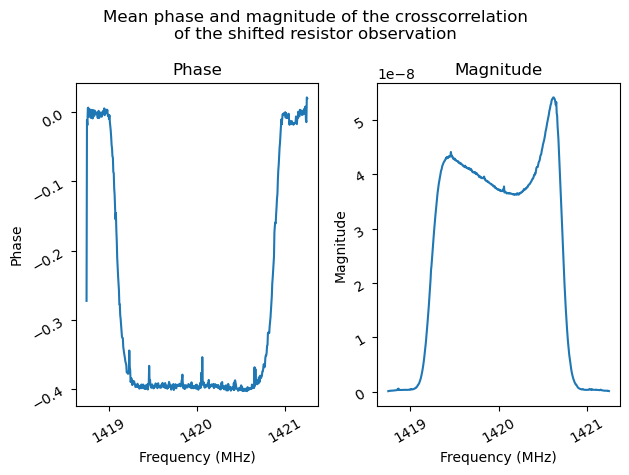

In [29]:
#### The sum of the phase over the time-axis can also be useful to see slight deviations.
#### It is plotted below.
#### If the phase plot is not a linear line going from -1 to 0 to 1, something is going wrong.
#### If the phase is chaos, its fucked, and if its smooth but not linear, then there is a sub-sample delay.

fig, (ax1, ax2) = plt.subplots(1, 2)
x = np.linspace(freq[0], freq[1], channels)
ax1.plot(x, cross_ang[:, :].mean(axis=0))
ax2.plot(x, cross_abs[:, :].mean(axis=0))
ax1.set_xlabel("Frequency (MHz)")
ax2.set_xlabel("Frequency (MHz)")
ax1.set_ylabel("Phase")
ax2.set_ylabel("Magnitude")
ax1.set_title("Phase")
ax2.set_title("Magnitude")
ax1.tick_params(rotation=30)
ax2.tick_params(rotation=30)
plt.suptitle("Mean phase and magnitude of the crosscorrelation\nof the shifted resistor observation")
plt.tight_layout()
plt.show()

In [ ]:
#### Code for sub-sample delay correction based on phase goes here.
#### (the code is mostly done, but its not here yet, ask Floris if you need it)

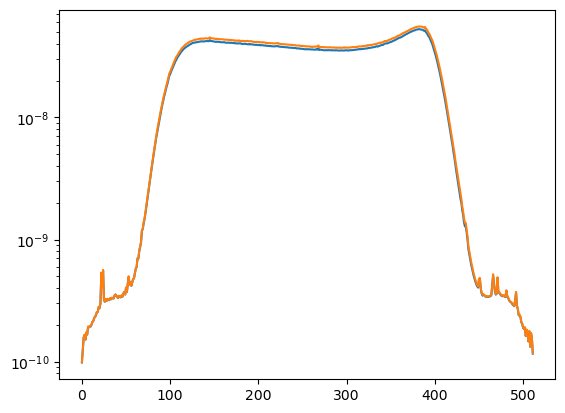

(0.0, 1.902110718932093e-10)

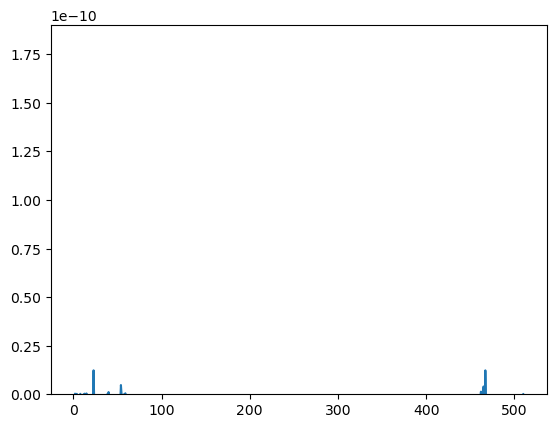

In [30]:
plt.plot(cross_abs[len(cross_abs)//2:].mean(axis=0))
plt.plot(cross_abs[:len(cross_abs)//2].mean(axis=0))
plt.yscale('log')
plt.show()

plt.plot(cross_abs[len(cross_abs)//2:].mean(axis=0) - cross_abs[:len(cross_abs)//2].mean(axis=0))
plt.ylim(0)